In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, recall_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import shap
import joblib

In [4]:
# 1. Loading data
df = pd.read_csv('/content/drive/MyDrive/loans50k.csv', encoding='latin-1')
pd.set_option('display.max_columns', None)

In [5]:
# 2. Creating a binary target variable
default_statuses = ['Default', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)']
df['default'] = df['status'].apply(lambda x: 1 if x in default_statuses else 0)
df.drop(['status', 'loanID'], axis=1, inplace=True)

In [6]:
# 3. Impute missing values
medians = {
    'revolRatio': df['revolRatio'].median(),
    'bcRatio': df['bcRatio'].median(),
    'bcOpen': df['bcOpen'].median(),
    'length': df['length'].mode()[0]
}

df['bcRatio'].fillna(medians['bcRatio'], inplace=True)
df['bcOpen'].fillna(medians['bcOpen'], inplace=True)
df['revolRatio'].fillna(medians['revolRatio'], inplace=True)
df['length'].fillna(medians['length'], inplace=True)
df['employment'].fillna('unknown', inplace=True)

/tmp/ipython-input-6-1690051675.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bcRatio'].fillna(medians['bcRatio'], inplace=True)
/tmp/ipython-input-6-1690051675.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [7]:
# 4. Convert length column
def convert_length(val):
    if val == '10+ years': return 10
    elif val == '< 1 year': return 0
    else: return int(val.strip().split()[0])

df['length_num'] = df['length'].apply(convert_length)
df.drop('length', axis=1, inplace=True)

In [8]:
# 5. Feature Engineering
df['loan_to_income'] = df['amount'] / df['income']
df['installment_to_income'] = df['payment'] / df['income']
df['high_dti_flag'] = (df['debtIncRat'] > 0.4).astype(int)
df['long_emp'] = (df['length_num'] > 5).astype(int)
df['log_income'] = np.log1p(df['income'])
df['log_loan_amt'] = np.log1p(df['amount'])
df['log_revol_bal'] = np.log1p(df['totalRevBal'])
df['income_bin'] = pd.qcut(df['income'], q=4, labels=False)
df['bcOpen_missing'] = df['bcOpen'].isnull().astype(int)
df['state_risk'] = df['state'].map(df.groupby('state')['default'].mean().to_dict())

In [9]:
# 6. Outlier Capping
def quantile_capping(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower, upper)
    return df[column]
for col in ['income', 'amount', 'debtIncRat', 'bcRatio', 'revolRatio']:
    quantile_capping(col)

In [10]:
# 7. Encoding

df['term'] = df['term'].apply(lambda x: 1 if x == "60 months" else 0)
df['grade'].fillna(df['grade'].mode()[0], inplace=True)
df['grade'] = df['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})
df = pd.get_dummies(df, columns=['reason', 'home', 'verified'], drop_first=True)
df.drop(['employment', 'state'], axis=1, inplace=True)

/tmp/ipython-input-10-3236645937.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['grade'].fillna(df['grade'].mode()[0], inplace=True)


In [11]:
# 8. Train-test split
X = df.drop('default', axis=1)
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
# 9. Imputation + Scaling
imputer = SimpleImputer(strategy='median')
X_train[['bcOpen', 'state_risk', 'grade']] = imputer.fit_transform(X_train[['bcOpen', 'state_risk', 'grade']])
X_test[['bcOpen', 'state_risk', 'grade']] = imputer.transform(X_test[['bcOpen', 'state_risk', 'grade']])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# 10. Model Training + Hyperparameter Tuning
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_dist = {
    "n_estimators": np.arange(300, 1600, 200),
    "learning_rate": np.linspace(0.01, 0.2, 10),
    "max_depth": np.arange(3, 11),
    "min_child_weight": np.arange(1, 10),
    "gamma": np.linspace(0, 5, 6),
    "subsample": np.linspace(0.6, 1.0, 5),
    "colsample_bytree": np.linspace(0.6, 1.0, 5),
    "scale_pos_weight": [4, 5, 6]
}
recall_1 = make_scorer(recall_score, pos_label=1)
rand_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=40, scoring=recall_1, cv=3, n_jobs=-1, verbose=2, random_state=42)
rand_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:38:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_child_weight': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 300,  500,  700,  900, 1100, 1300, 1500]),
                                        'scale_pos_weight': [4, 5, 6],
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42,
                   scoring=make_scorer(recall_score, response_method='predict', pos_label=1),
                   verbose=2)

In [14]:
# 11. Evaluation
best_xgb = rand_search.best_estimator_
y_pred = best_xgb.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7854  520]
 [ 227 1399]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      8374
           1       0.73      0.86      0.79      1626

    accuracy                           0.93     10000
   macro avg       0.85      0.90      0.87     10000
weighted avg       0.93      0.93      0.93     10000



<Figure size 1200x600 with 0 Axes>

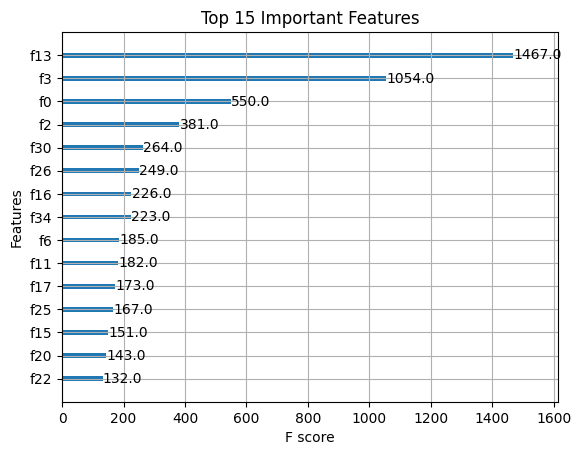

In [15]:
# 12. Feature Importance
plt.figure(figsize=(12,6))
plot_importance(best_xgb, max_num_features=15)
plt.title('Top 15 Important Features')
plt.show()

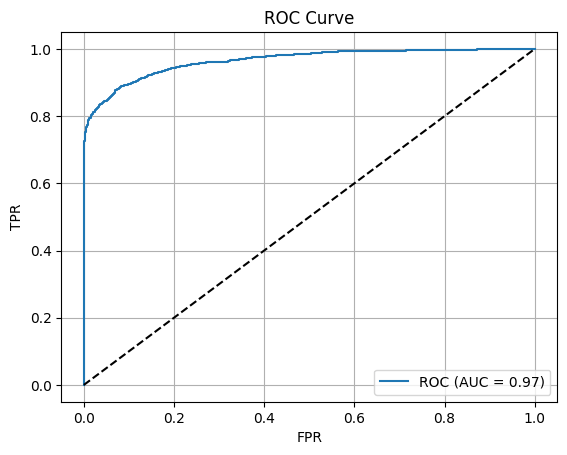

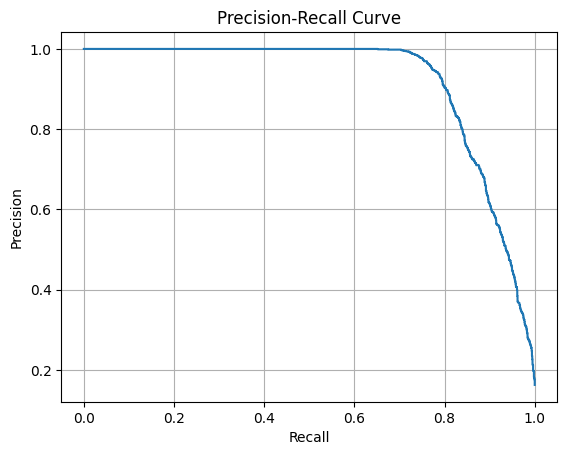

In [16]:
# 13. ROC & PR Curve
y_probs = best_xgb.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

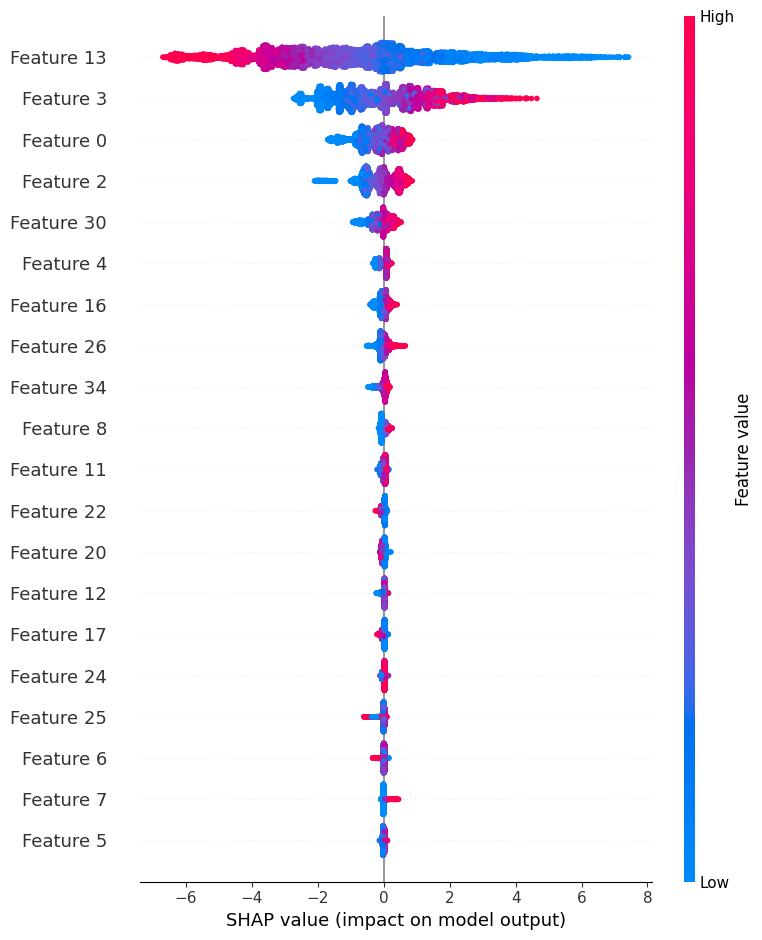

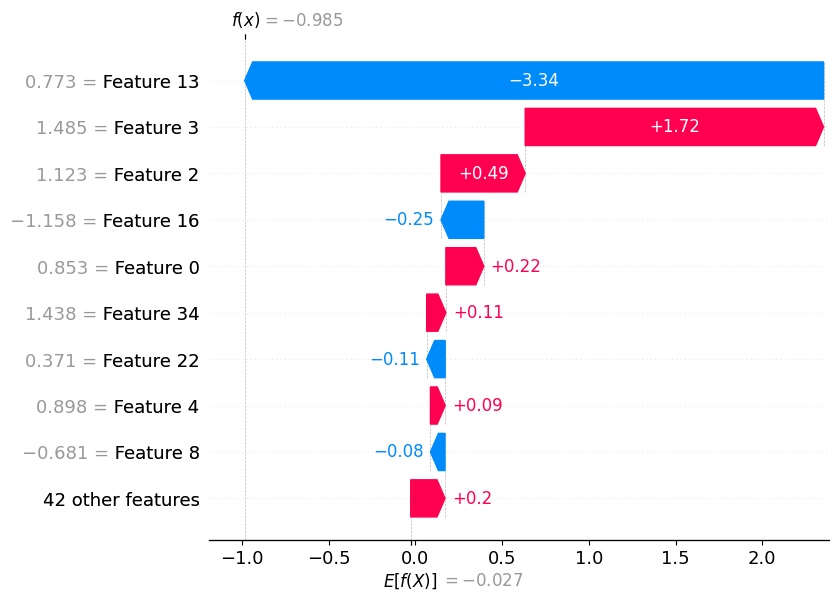

In [17]:
# 14. SHAP Explainability
shap.initjs()
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled)
shap.plots.waterfall(shap_values[50])

In [18]:
# 15. Save model and scaler
joblib.dump(best_xgb, "xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']